In [105]:
pip install tensorflow_quantum

In [106]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [107]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy
import cv2
# for reading and displaying images
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score

In [108]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [109]:
def rgbgrey(img):
    # Converts rgb to grayscale
    greyimg = np.zeros((img.shape[0], img.shape[1]))
    for row in range(len(img)):
        for col in range(len(img[row])):
            greyimg[row][col] = np.average(img[row][col])
    return greyimg

def greybin(img):
    # Converts grayscale to binary
    blur_radius = 0.8
    img = scipy.ndimage.gaussian_filter(img, blur_radius)  # to remove small components or noise
#     img = ndimage.binary_erosion(img).astype(img.dtype)
    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg

def preproc(path, img=None, display=True):
    if img is None:
        img =imread(path)
        #grey = rgbgrey(img) #rgb to grey
        grey=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        binimg = greybin(grey) #grey to binary
    """if display:
        
        #plt.imshow(img)
        #plt.show()
    if display:
        #plt.imshow(grey, cmap = matplotlib.cm.Greys_r)
        #plt.show()
    if display:
        #plt.imshow(binimg, cmap = matplotlib.cm.Greys_r)
        #plt.show()
    """
    r, c = np.where(binimg==1)
    # Now we will make a bounding box with the boundary as the position of pixels on extreme.
    # Thus we will get a cropped image with only the signature part.
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    """if display:
        plt.imshow(signimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    """
    return signimg

In [ ]:
train_data = pd.read_excel("gdrive/My Drive/code/sign_data/trainer.xlsx")
test_data = pd.read_excel("gdrive/My Drive/code/sign_data/tester.xlsx")

In [ ]:
train_path = "gdrive/My Drive/code/sign_data/train/"
test_path = "gdrive/My Drive/code/sign_data/test/"
train = train_data
test = test_data

In [ ]:
train.head()

,068_forg/03_0113068.PNG,1
0,068_forg/01_0124068.PNG,1
1,068_forg/02_0124068.PNG,1
2,068_forg/01_0113068.PNG,1
3,068_forg/04_0124068.PNG,1
4,068_forg/04_0113068.PNG,1


In [ ]:
train_img = []
for img_name in tqdm(train["068_forg/03_0113068.PNG"]):
    image_path = train_path + img_name
    #Preprocessing
    img=preproc(image_path)
    # appending the image into the list
    img =resize(img, output_shape=(250,600), mode='constant', anti_aliasing=True)
    train_img.append(img)

100%|██████████| 1648/1648 [00:42<00:00, 38.85it/s]


In [ ]:
test

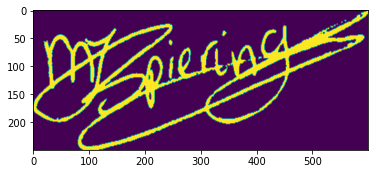

In [ ]:
plt.imshow(img)
plt.show()
train_x = np.array(train_img)
train_x= np.expand_dims(train_x, axis=-1)
train_y=train[1]

In [ ]:
test_img = []
for img_name in tqdm(test["068_forg/03_0113068.PNG"]):
    image_path = test_path + img_name
    #Preprocessing
    img=preproc(image_path)
    # appending the image into the list
    img =resize(img, output_shape=(250,600), mode='constant', anti_aliasing=True)
    test_img.append(img)

100%|██████████| 499/499 [01:42<00:00,  4.87it/s]


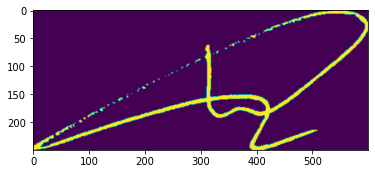

In [ ]:
plt.imshow(img)
plt.show()
test_x = np.array(test_img)
test_x= np.expand_dims(test_x, axis=-1)
test_y=test[1]

In [ ]:
print("Number of original training examples:", len(train_x))
print("Number of original test examples:", len(test_x))

Number of original training examples: 1648
Number of original test examples: 499


In [ ]:
train_small = tf.image.resize(train_x, (16, 16)).numpy()
test_small = tf.image.resize(test_x, (16, 16)).numpy()

1


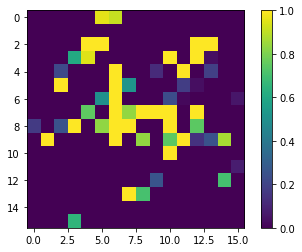

In [ ]:
print(train_y[0])

plt.imshow(train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(labels.pop())
      else:
          # Throw out images that match more than one label.
          pass

    forg = sum(1 for value in mapping.values() if True in value)
    genu = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))

    return np.array(new_x), np.array(new_y)


In [ ]:
x_train_nocon, y_train_nocon = remove_contradicting(train_small, train_y)

Number of unique images: 1360
Number of contradictory images:  1

Initial number of examples:  1648
Remaining non-contradictory examples:  1359


In [ ]:
x_train = x_train_nocon
x_test = test_small 

In [ ]:
def convert_to_circuit(image):
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(16, 16)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train]
x_test_circ = [convert_to_circuit(x) for x in x_test]

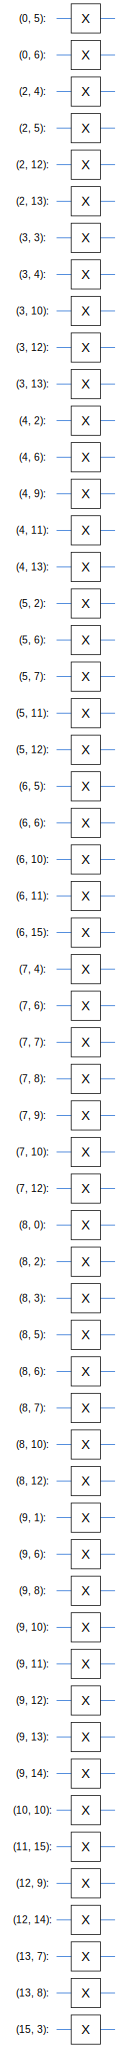

In [ ]:
SVGCircuit(x_train_circ[0])

In [ ]:
bin_img = x_train[0,:,:,0]
bin_img

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.96015626, 0.9132812 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.6075328 , 0.95296246,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.03574219, 0.        ,
        0.        ],
       [0.        , 0.        , 0.21875   , 0.        , 0.        ,
        0.        , 1.        , 

In [ ]:
s=np.array(np.where(bin_img))
s

array([[ 0,  0,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
         5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
         7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,
         9, 10, 11, 12, 12, 13, 13, 15],
       [ 5,  6,  4,  5, 12, 13,  3,  4, 10, 12, 13,  2,  6,  9, 11, 13,
         2,  6,  7, 11, 12,  5,  6, 10, 11, 15,  4,  6,  7,  8,  9, 10,
        12,  0,  2,  3,  5,  6,  7, 10, 12,  1,  6,  8, 10, 11, 12, 13,
        14, 10, 15,  9, 14,  7,  8,  3]])

In [ ]:
indices = np.array(np.where(bin_img)).T
indices

array([[ 0,  5],
       [ 0,  6],
       [ 2,  4],
       [ 2,  5],
       [ 2, 12],
       [ 2, 13],
       [ 3,  3],
       [ 3,  4],
       [ 3, 10],
       [ 3, 12],
       [ 3, 13],
       [ 4,  2],
       [ 4,  6],
       [ 4,  9],
       [ 4, 11],
       [ 4, 13],
       [ 5,  2],
       [ 5,  6],
       [ 5,  7],
       [ 5, 11],
       [ 5, 12],
       [ 6,  5],
       [ 6,  6],
       [ 6, 10],
       [ 6, 11],
       [ 6, 15],
       [ 7,  4],
       [ 7,  6],
       [ 7,  7],
       [ 7,  8],
       [ 7,  9],
       [ 7, 10],
       [ 7, 12],
       [ 8,  0],
       [ 8,  2],
       [ 8,  3],
       [ 8,  5],
       [ 8,  6],
       [ 8,  7],
       [ 8, 10],
       [ 8, 12],
       [ 9,  1],
       [ 9,  6],
       [ 9,  8],
       [ 9, 10],
       [ 9, 11],
       [ 9, 12],
       [ 9, 13],
       [ 9, 14],
       [10, 10],
       [11, 15],
       [12,  9],
       [12, 14],
       [13,  7],
       [13,  8],
       [15,  3]])

In [110]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

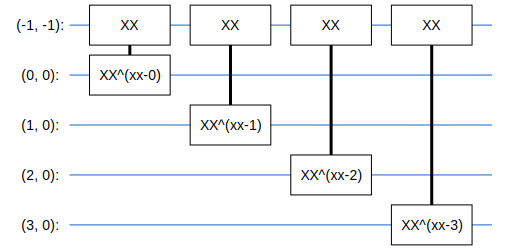

In [ ]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [ ]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(16, 16)  # a 16*16 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers .
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
model_circuit, model_readout = create_quantum_model()

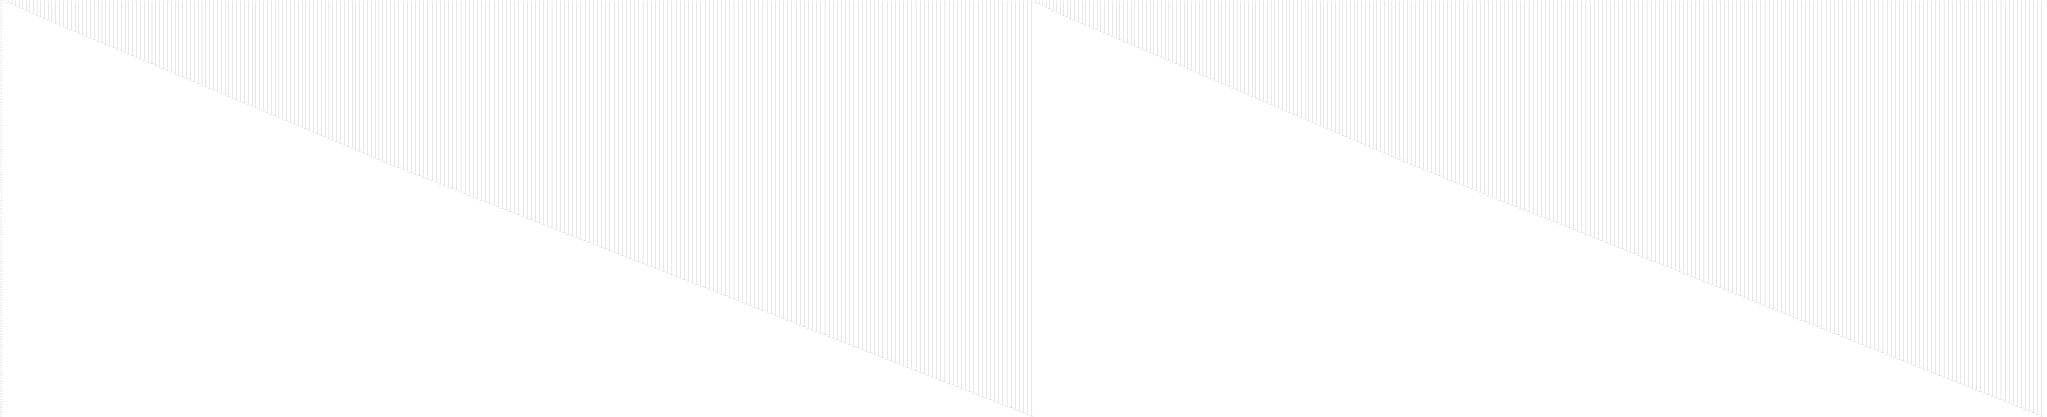

In [ ]:
SVGCircuit(model_circuit)

In [ ]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*test_y-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [ ]:
y_train_hinge_sub

array([ 1.,  1.,  1., ..., -1., -1., -1.])

In [111]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))


Epoch 1/10
43/43 [==============================] - 29s 669ms/step - loss: 1.0478 - hinge_accuracy: 0.4735 - val_loss: 1.0100 - val_hinge_accuracy: 0.4918
Epoch 2/10
43/43 [==============================] - 28s 662ms/step - loss: 1.0478 - hinge_accuracy: 0.4751 - val_loss: 1.0100 - val_hinge_accuracy: 0.4918
Epoch 3/10
43/43 [==============================] - 28s 661ms/step - loss: 1.0478 - hinge_accuracy: 0.4751 - val_loss: 1.0100 - val_hinge_accuracy: 0.4918
Epoch 4/10
43/43 [==============================] - 29s 672ms/step - loss: 1.0478 - hinge_accuracy: 0.4751 - val_loss: 1.0100 - val_hinge_accuracy: 0.4918
Epoch 5/10
43/43 [==============================] - 29s 665ms/step - loss: 1.0478 - hinge_accuracy: 0.4735 - val_loss: 1.0100 - val_hinge_accuracy: 0.4918
Epoch 6/10
43/43 [==============================] - 28s 659ms/step - loss: 1.0478 - hinge_accuracy: 0.4768 - val_loss: 1.0100 - val_hinge_accuracy: 0.4918
Epoch 7/10
43/43 [==============================] - 29s 673ms/step - l

In [ ]:
qnn_results = model.evaluate(x_test_tfcirc, test_y)

16/16 [==============================] - 4s 250ms/step - loss: 1.0100 - hinge_accuracy: 0.4918
